In [19]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [20]:
# Initialising the CNN
classifier = Sequential()

In [21]:
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

In [22]:
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [23]:
# Step 3 - Flattening
classifier.add(Flatten())

In [24]:
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [27]:
# Part 2 - Fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('image_datasets/training_set',target_size = (64, 64),batch_size = 32, class_mode = 'binary')


Found 1589 images belonging to 2 classes.


In [32]:
test_set = test_datagen.flow_from_directory('image_datasets/test_set',
target_size = (64, 64),
batch_size = 32,
class_mode = 'binary')
classifier.fit_generator(training_set,
steps_per_epoch = 8000,
epochs = 2,
validation_data = test_set,
validation_steps = 2000)

Found 378 images belonging to 2 classes.
Epoch 1/2
8000/8000 [==============================] - 3050s 381ms/step - loss: 0.0075 - acc: 0.9976 - val_loss: 2.4308 - val_acc: 0.7250
Epoch 2/2
8000/8000 [==============================] - 944s 118ms/step - loss: 0.0072 - acc: 0.9980 - val_loss: 2.6851 - val_acc: 0.7273


In [59]:
# Part 3 - Making new predictions
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('image_datasets/test_set/cats/cat.4007.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
# training_set.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'

dog
(310, 174, 3)


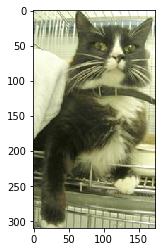

In [222]:
print(prediction)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('image_datasets/test_set/cats/cat.4007.jpg')
print(np.shape(img))
imgplot = plt.imshow(img)
plt.show()

In [45]:
#Get an explanation from LIME-KNN, in the form of an HTML page string.
explanation = lime.lime_knn_image.explainInstanceUsingKNN(originalClassifier=classifier,instancePoint=test_image,num_samples=1000,num_neighbours=5,feature_names=grid_location,class_names=target_names,dataPointInterpretation="Animal")

NameError: name 'grid_location' is not defined

In [44]:
import lime.lime_knn_image

In [61]:
target_names = ['cat','dog']
grid_location = np.linspace(1,16,16)
print(np.shape(grid_location))

(16,)


In [146]:
result2 = classifier.predict(test_image)
print(result2)
print(test_image.shape)

[[1.]]
(1, 64, 64, 3)


In [157]:
"""
# Old function
subpixelSize=256
def trainingDataInVicinity(instancePointin1D, num_samples, stdDev):
    numFeatures = 16*3 # number of subpixels
    perturbations = np.random.normal(0,stdDev,num_samples*numFeatures*subpixelSize) # this should make sure that the range is same
    trainingDataInVicinity = np.empty([num_samples,numFeatures*subpixelSize], dtype = np.uint8) # this should be final size of image
    
    for i in range(num_samples):
        for j in range(numFeatures): # apply to each feature
            # Actually I would like to extract it here
            a = instancePointin1D[j*subpixelSize:subpixelSize*(j+1)]
            # print(np.shape(a))
            indInPert = i*numFeatures + j
            b = perturbations[indInPert*subpixelSize:subpixelSize*(indInPert+1)]
            c = a + b
            for k in range(subpixelSize):
                trainingDataInVicinity[i][j*subpixelSize+k] = c[k]
           
    return trainingDataInVicinity

subpixelSize=256
sizeImage=64*64
# NEW PART1
def trainingDataInVicinity(instancePointin1D, num_samples, stdDev):
    numFeatures = 16*3 # number of subpixels
    perturbations = np.random.normal(0,stdDev,num_samples*numFeatures) # this should make sure that the range is same
    trainingDataInVicinity = np.empty([num_samples,sizeImage*3], dtype = np.uint8) # this should be final size of image
    
    for i in range(num_samples):
        trainingDataInVicinity[i] = instancePointin1D
        for j in range(numFeatures): # apply to each feature
            indInPert = i*numFeatures + j
            b = perturbations[indInPert]
            # extract from number of features
            start_xind = int(((j%sizeImage)/16)%4)*16
            start_yind = int(((j%sizeImage)/16)/4)*16
            zind = int(j/16)
            # print("j: ",j)
            # print("start_xind: ",start_xind)
            # print("start_yind: ",start_yind)
            # print("zind: ", zind)
            for k in range(start_yind, start_yind+16): # 16x16
                for p in range(start_xind, start_xind+16):
                    trainingDataInVicinity[i][zind*sizeImage+k*64+p] += b
                    
                    
subpixelSize=256
sizeImage=64*64
# NEW PART2
import random
def trainingDataInVicinity(instancePointin1D, num_samples, stdDev):
    numFeatures = 16*3 # number of subpixels
    perturbations = np.random.normal(0,stdDev,num_samples*numFeatures) # this should make sure that the range is same
    trainingDataInVicinity = np.empty([num_samples,sizeImage*3], dtype = float) # this should be final size of image
    
    # could we shade everything except one subpixel?
    for i in range(num_samples):
        trainingDataInVicinity[i] = instancePointin1D
        j = random.randint(0,numFeatures-1)
        b = perturbations[i*numFeatures + j]
        # extract from number of features
        start_xind = int(((j%sizeImage)/16)%4)*16
        start_yind = int(((j%sizeImage)/16)/4)*16
        zind = int(j/16)
        for k in range(start_yind, start_yind+16): # 16x16
            for p in range(start_xind, start_xind+16):
                trainingDataInVicinity[i][zind*sizeImage+k*64+p] += b*10
           
    return trainingDataInVicinity
"""

In [233]:
subpixelSize=256
sizeImage=64*64
# NEW PART3
import random
def trainingDataInVicinity(instancePointin1D, num_samples, stdDev):
    numFeatures = 16*3 # number of subpixels
    perturbations = np.random.normal(0,stdDev,num_samples*numFeatures) # this should make sure that the range is same
    trainingDataInVicinity = np.empty([num_samples,sizeImage*3], dtype = float) # this should be final size of image
    
    # could we shade everything except one subpixel?
    
    for i in range(num_samples):
        trainingDataInVicinity[i] = instancePointin1D
        specialFeature = random.randint(0,numFeatures-1)
        for j in range(numFeatures):
            if j==specialFeature:
                continue
            b = perturbations[i*numFeatures + j]
            # extract from number of features
            start_xind = int(((j%sizeImage)/16)%4)*16
            start_yind = int(((j%sizeImage)/16)/4)*16
            zind = int(j/16)
            for k in range(start_yind, start_yind+16): # 16x16
                for p in range(start_xind, start_xind+16):
                    trainingDataInVicinity[i][zind*sizeImage+k*64+p] = 255
           
    return trainingDataInVicinity

from sklearn.neighbors import KNeighborsClassifier

def explainInstanceUsingKNN(originalClassifier=None,instancePoint=None,num_samples=1000,num_neighbors=5,feature_names=None,class_names=None,dataPointInterpretation="Data Points",scalar=None):
    print(test_image.shape)
    instancePointLabel = originalClassifier.predict(instancePoint)
    print(instancePointLabel)
    
    instancePointIn1D = instancePoint.flatten()
    print(np.shape(instancePointIn1D))
    
    trainingDataIn1D = trainingDataInVicinity(instancePointIn1D, num_samples, 1)
    
    labelOfDataInVicinity = np.empty([num_samples,1])
    
    for i in range(num_samples):
        test_instance = np.reshape(trainingDataIn1D[i], (1,64,64,3))
        labelOfDataInVicinity[i] = originalClassifier.predict(test_instance)
    
    # Run the kNN classifier, with this ground truth
    knnClassifier = KNeighborsClassifier(num_neighbors)
    knnClassifier.fit(trainingDataIn1D, labelOfDataInVicinity)
    
    instancePointIn2darray = np.reshape(instancePointIn1D,(1,-1))
    distance, indices = knnClassifier = knnClassifier.kneighbors(instancePointIn2darray, num_neighbors)
    
    # Get all the similar points with the same label
    similarPointsForExplanation = []
    for index in indices[0]:
        if labelOfDataInVicinity[index]==instancePointLabel:
            similarPointsForExplanation.append(trainingDataIn1D[index])
            
    # Now, I want to see this as an image
    return similarPointsForExplanation
    # outPoint = np.reshape(similarPointsForExplanation[0], (1,64,64,3))
    # return outPoint
    
    
    
explanations = explainInstanceUsingKNN(originalClassifier=classifier,instancePoint=test_image,num_samples=1000,num_neighbors=5,feature_names=grid_location,class_names=target_names,dataPointInterpretation="Animal")

(1, 64, 64, 3)
[[1.]]
(12288,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(5, 12288)


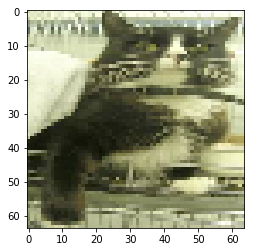

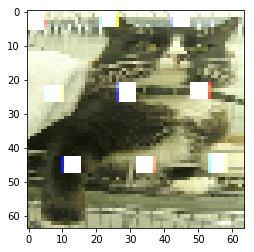

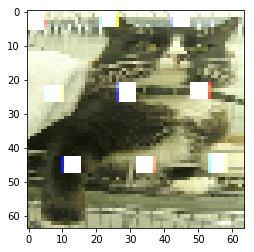

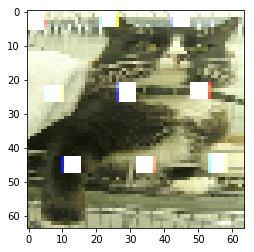

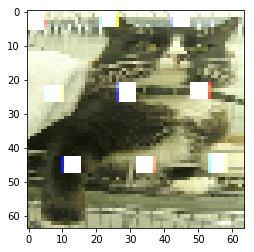

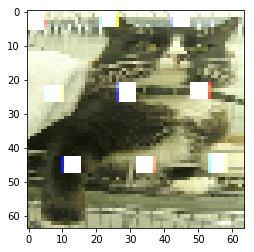

In [234]:
print(np.shape(explanations))
test_image_original = image.load_img('image_datasets/test_set/cats/cat.4007.jpg', target_size = (64, 64))
img_original = image.img_to_array(test_image_original)
imgplot = plt.imshow(img_original.astype(np.uint8))
plt.show()
for i in range(5):
    img = np.reshape(explanations[i],(64,64,3))
    # img_mode = np.clip(img, 0, 1)
    xy = plt.imshow(img.astype(np.uint8))
    plt.show()